Imports

In [1]:
# Import necessari
import cv2
import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import json
import torchvision
from torchvision.models.detection import maskrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

Dataset preparation

DATASET CLASS

In [2]:
import os
import glob
from PIL import Image
import os
import glob
from PIL import Image

class ParkingLotDataset(Dataset):
    def __init__(self, root_img, root_msk, pairs=None, transforms=None, mask_transforms=None):
        self.root_img = root_img
        self.root_msk = root_msk
        self.transforms = transforms
        self.mask_transforms = mask_transforms

        if pairs is None:
            # Get all image files
            self.image_paths = sorted(glob.glob(os.path.join(root_img, '*.png')))

            # Get all mask files
            self.mask_paths = sorted(glob.glob(os.path.join(root_msk, '*.png')))

            # Pair image and mask files based on their filenames
            #self.pairs = [(image_path, mask_path) for image_path in self.image_paths for mask_path in self.mask_paths if os.path.splitext(os.path.basename(image_path))[0] == os.path.splitext(os.path.basename(mask_path))[0]]
            self.pairs = []

            for image_path in self.image_paths:
                image_filename = os.path.splitext(os.path.basename(image_path))[0]
                mask_filename = f"{image_filename}_SegmentationClass.png"
                mask_path = os.path.join(root_msk, mask_filename)
                if os.path.exists(mask_path):
                    self.pairs.append((image_path, mask_path))

        else:
            self.pairs = pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx, threshold=0.5):
        image_path, mask_path = self.pairs[idx]

        # Load image
        image = Image.open(image_path)
        image_array = np.array(image)
        self.input_channels = image_array.shape[0]

        # Apply transformations
        if self.transforms:
            image_array = self.transforms(image_array)
        
        #mask = Image.open(mask_path)
        #mask_array = np.array(mask)
        mask_array = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        mask_array = (mask_array > threshold).astype(np.float32)
        self.input_channels = mask_array.shape[0]

        # Apply transformations
        if self.mask_transforms:
            mask_array = self.mask_transforms(mask_array)


        return image_array, mask_array
        


DATASET SLPIT

In [3]:
import random
from torch.utils.data import random_split
from torchvision.transforms import functional as F

# magari rifare il dataloader con due cartelle
image_path = '/kaggle/input/resized-no-pad/Resize_no_padding'
mask_path = '/kaggle/input/resized-mask-no-pad'

#normalize = transforms.Normalize(mean=[0.5], std=[0.5])
#normalize = transforms.Normalize(mean=[35.5, 35.2, 33.4], std=[21.8, 21.6, 20.9])

transform = transforms.Compose([
    
    transforms.ToTensor(),
    
    #transforms.Normalize(mean=[35.5, 35.2, 33.4], std=[21.8, 21.6, 20.9]),
    # Add other transforms here as needed
])

mask_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5], std=[0.5]),
    # Add other mask transformations here
])


# Create the dataset
dataset = ParkingLotDataset(image_path, mask_path, transforms=transform, mask_transforms=mask_transforms)

# Define the proportions for the split
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

total_size = len(dataset)
print(total_size)

# Shuffle the dataset
random.shuffle(dataset.pairs)

# Calculate the sizes of each split
total_size = len(dataset)
print(total_size)
train_size = int(train_ratio * total_size)
val_size = int(val_ratio * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_pairs = dataset.pairs[:train_size]
val_pairs = dataset.pairs[train_size:train_size+val_size]
test_pairs = dataset.pairs[train_size+val_size:]

# Create datasets for each split
train_dataset = ParkingLotDataset(image_path, mask_path, transforms=transform, mask_transforms=mask_transforms)
val_dataset = ParkingLotDataset(image_path, mask_path, transforms=transform, mask_transforms=mask_transforms)
test_dataset = ParkingLotDataset(image_path, mask_path, transforms=transform, mask_transforms=mask_transforms)

# Now you can create data loaders for each split
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False) 


499
499


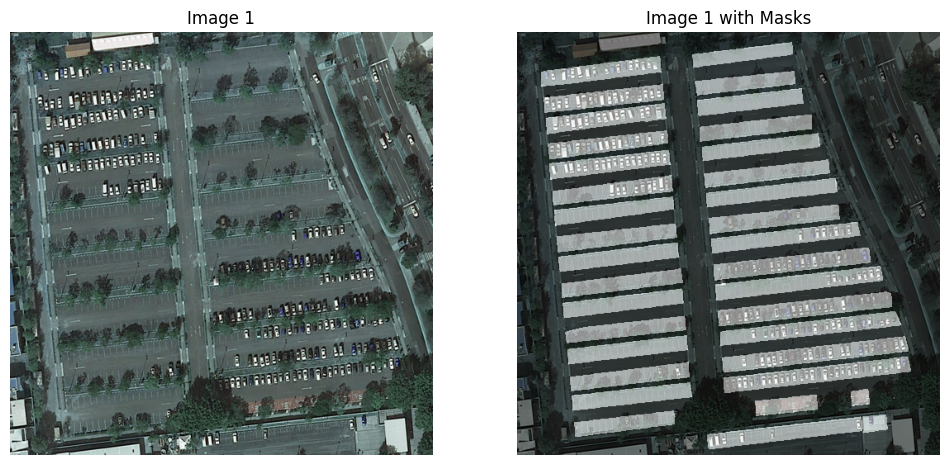

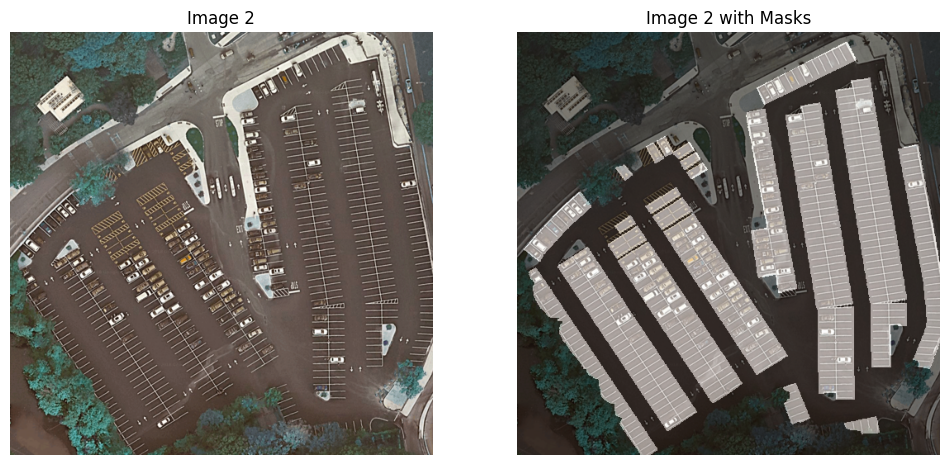

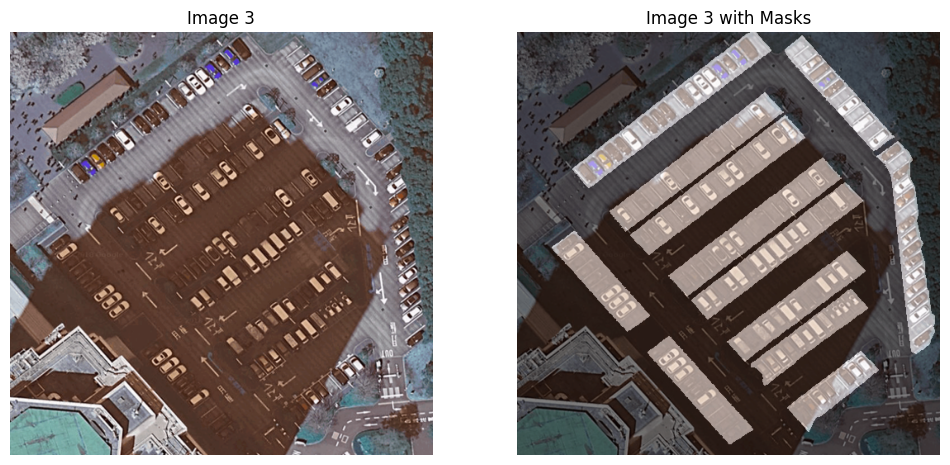

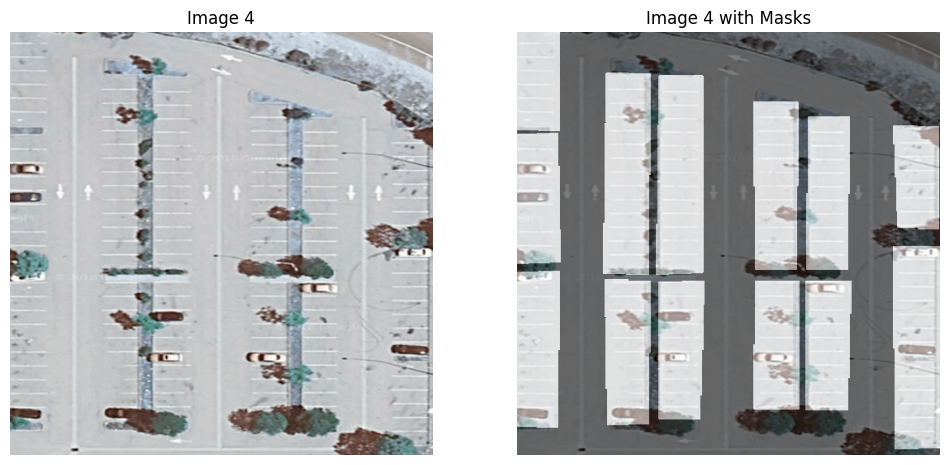

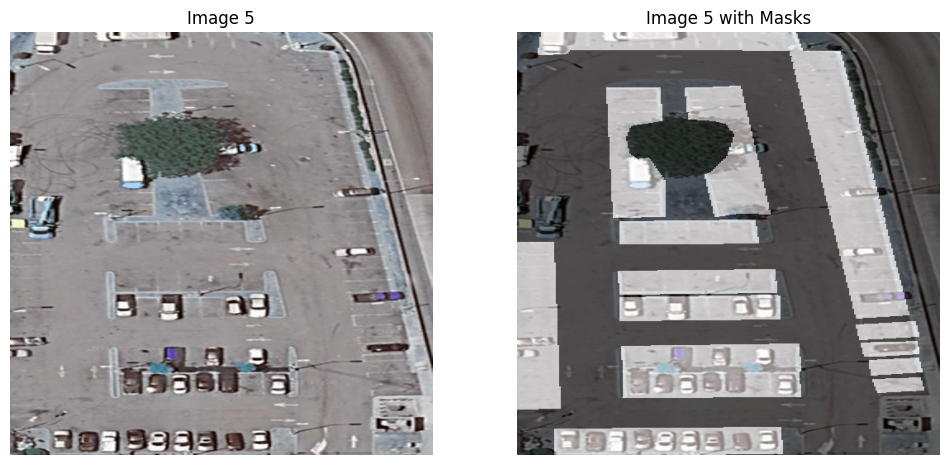

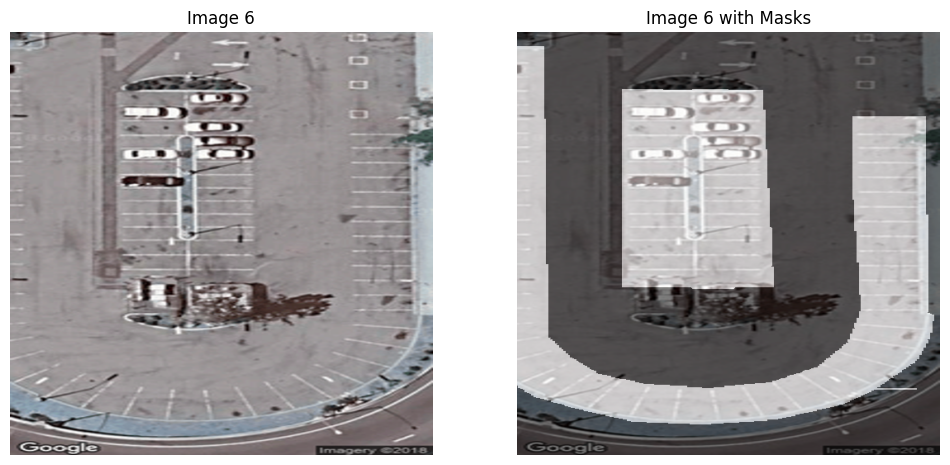

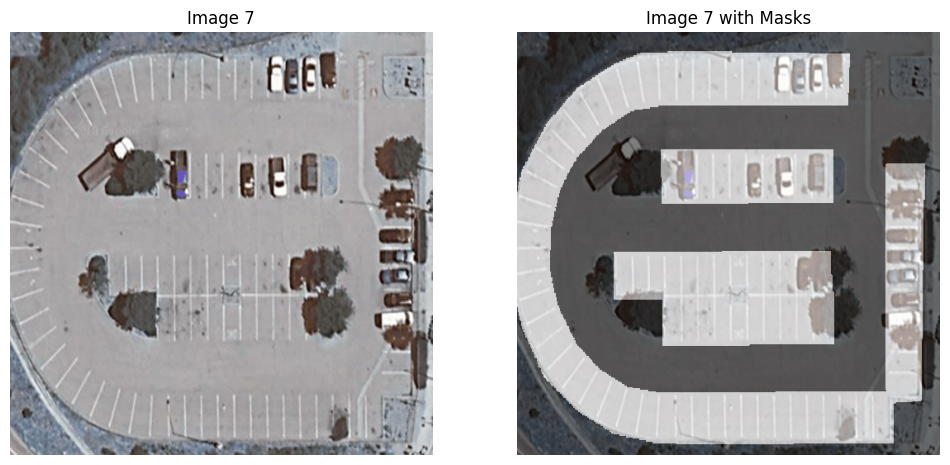

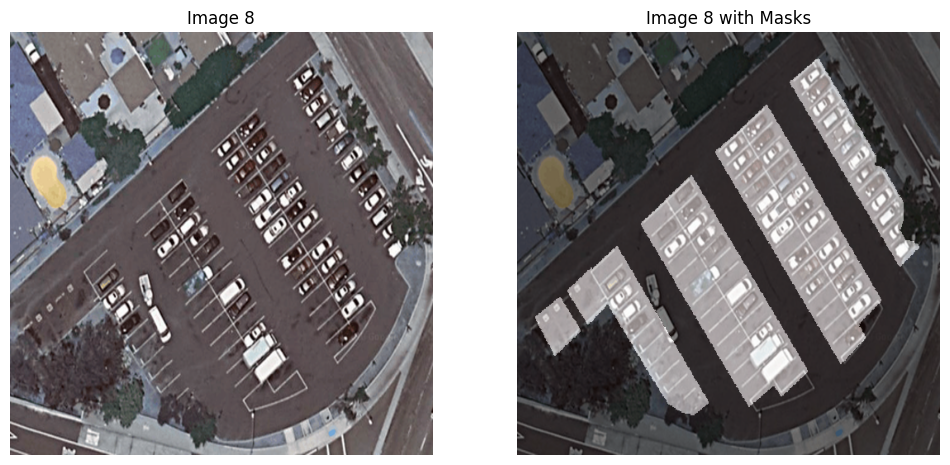

In [4]:
import matplotlib.pyplot as plt

# Assuming you have a DataLoader object called train_loader
num_samples = 10

# Iterate over batches from the DataLoader
for batch_idx, (images, masks) in enumerate(train_loader):
    # Get the number of samples in the current batch
    batch_size = images.size(0)

    # Iterate over the samples in the batch
    for i in range(batch_size):
        # Convert the image tensor to a NumPy array
        image_array = images[i].permute(1, 2, 0).numpy()

        # Convert the mask tensor to a NumPy array
        mask_array = masks[i].numpy()

        # Plot the image and the combined mask
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(image_array)
        plt.title(f'Image {batch_idx * batch_size + i + 1}')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(image_array)
        plt.imshow(mask_array[0], cmap='gray', alpha=0.5)
        plt.title(f'Image {batch_idx * batch_size + i + 1} with Masks')
        plt.axis('off')

        plt.show()

        # Break after the first 10 samples
        if batch_idx * batch_size + i == num_samples - 1:
            break

    # Break after processing one batch
    if batch_idx == 0:
        break

Model

In [5]:
import torch.nn as nn
import torch.nn.functional as F

class SmallUNet_RGB(nn.Module):
    def __init__(self):
        super(SmallUNet_RGB, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.maxpool = nn.MaxPool2d(2)

        # Decoder
        self.upconv3 = nn.Conv2d(384, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.upconv2 = nn.Conv2d(192, 64, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(64)
        self.upconv1 = nn.Conv2d(96, 32, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(32)
        self.final_conv = nn.Conv2d(32, 1, 1)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        # Encoder
        conv1 = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(conv1)
        conv2 = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(conv2)
        conv3 = F.relu(self.bn3(self.conv3(x)))
        x = self.maxpool(conv3)
        x = F.relu(self.bn4(self.conv4(x)))

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = F.relu(self.bn5(self.upconv3(x)))
        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = F.relu(self.bn6(self.upconv2(x)))
        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = F.relu(self.bn7(self.upconv1(x)))
        out = self.final_conv(x)

        return out

In [ ]:
import torch.nn.functional as F

def dice_loss(pred, target, smooth=1e-6):
    pred = pred.contiguous()
    target = target.contiguous()
    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)
    
    return 1 - loss.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.5, weight_bce=0.5):
        super(CombinedLoss, self).__init__()
        self.weight_dice = weight_dice
        self.weight_bce = weight_bce

    def forward(self, outputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(outputs, targets)
        dice = dice_loss(torch.sigmoid(outputs), targets)
        return self.weight_bce * bce_loss + self.weight_dice * dice


Train

In [6]:
from torch.utils.data import DataLoader
from torch import optim
import torch.nn.functional as F
import wandb
from torch.optim.lr_scheduler import StepLR
from torch import save

# Start a new run
#from Architetture import SmallUNet_RGB


#wandb.login('cf05b564865bb4bf8601ed59cbace5b02a587fa9')
#os.environ['WANDB_API_KEY'] = 'cf05b564865bb4bf8601ed59cbace5b02a587fa9'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SmallUNet_RGB().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=20, gamma=0.1) #after 20 epochs the lr becomes 0.001 and after 40 0.0001
criterion = CombinedLoss()
epochs = 25

#run = wandb.init(
    # Set the project where this run will be logged
    #project="Parking_lot_zones",
    # Track hyperparameters and run metadata
    #config={
        #"learning_rate": 0.01,
        #"epochs": epochs,
    #},
    #entity='lorenzo_barbieri'
    #entity='occelli-2127855'
#)

for epoch in range(epochs):
    model.train()
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(images)
        pos_weight = torch.tensor([masks.sum() / (1 - masks).sum()]).to(device)
        loss = criterion(outputs, masks)
        #loss = F.binary_cross_entropy(outputs, masks)
        loss.backward()
        optimizer.step()

        #wandb.log({"Train Loss": loss.item()})

    model.eval()
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device, dtype=torch.float32)

            outputs = model(images)
            val_loss = criterion(outputs, masks)    
            #val_loss = F.binary_cross_entropy(outputs, masks)

            #wandb.log({"Validation Loss": val_loss.item()})
        if epoch == 19:
            save(model.state_dict(), 'saved_model_20_epoch.pth')
            print("Model saved after 20 epochs.")
        if epoch == 49:
            save(model.state_dict(), 'saved_model_50_epoch.pth')
            print("Model saved after 50 epochs.")
            
    scheduler.step()
    print(f"Epoch {epoch+1}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Epoch 1, Training Loss: 0.37583300471305847, Validation Loss: 0.5363974571228027
Epoch 2, Training Loss: 0.3219226598739624, Validation Loss: 0.486698716878891
Epoch 3, Training Loss: 0.2984088361263275, Validation Loss: 0.46926361322402954
Epoch 4, Training Loss: 0.2862693965435028, Validation Loss: 0.45685523748397827
Epoch 5, Training Loss: 0.2776194214820862, Validation Loss: 0.44688519835472107
Epoch 6, Training Loss: 0.2701960802078247, Validation Loss: 0.4376859664916992
Epoch 7, Training Loss: 0.2635212242603302, Validation Loss: 0.42952150106430054
Epoch 8, Training Loss: 0.25739842653274536, Validation Loss: 0.4217061698436737
Epoch 9, Training Loss: 0.25177788734436035, Validation Loss: 0.4136802554130554
Epoch 10, Training Loss: 0.2466754913330078, Validation Loss: 0.4060942530632019
Epoch 11, Training Loss: 0.2422095239162445, Validation Loss: 0.3992486000061035
Epoch 12, Training Loss: 0.2382032722234726, Validation Loss: 0.39334067702293396
Epoch 13, Training Loss: 0.234

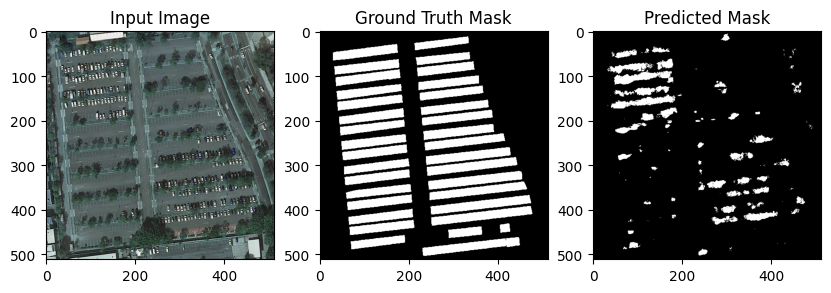

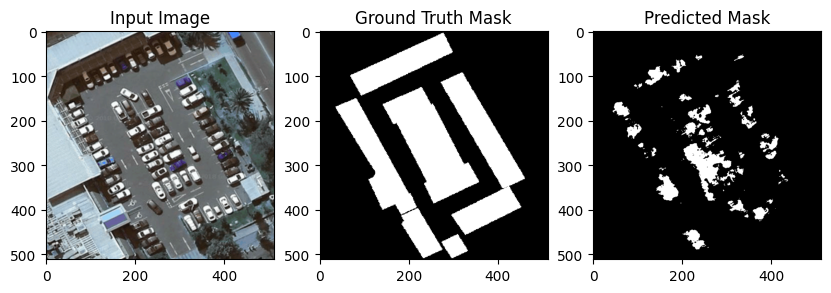

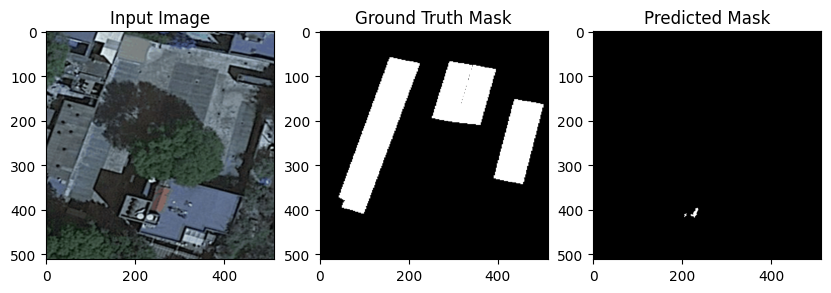

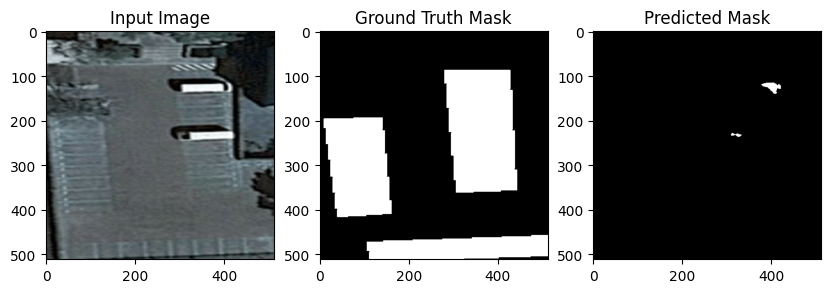

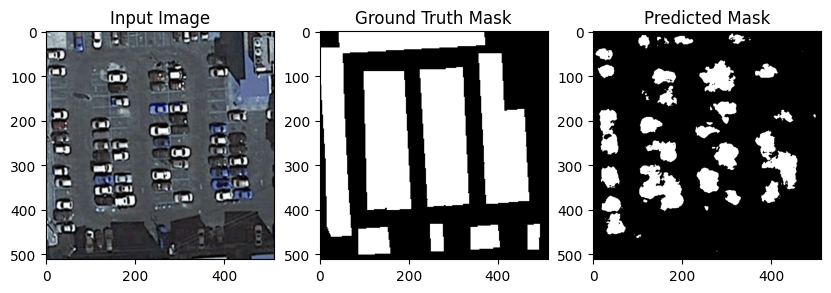

Accuracy on test set: 76.07%


In [7]:
import torch
import matplotlib.pyplot as plt


model.eval()

# Testing loop
total = 0
correct = 0
batch_idx = 0
with torch.no_grad():
    for batch in test_loader:
        images, masks = batch[:2]  # Unpack the first two values (images and masks)
        images = images.to(device)
        masks = masks.to(device, dtype=torch.float32)
        outputs = model(images)

        # Threshold the outputs to obtain binary masks
        predicted = (outputs > 0.5).float()

        # Compute the accuracy
        total += masks.numel()  # Total number of elements in the batch
        correct += (predicted == masks).sum().item()  # Correctly predicted elements

        # Plot the first 5 outputs
        if batch_idx < 5:
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[0].permute(1, 2, 0).cpu().numpy())
            plt.title('Input Image')
            plt.subplot(1, 3, 2)
            plt.imshow(masks[0][0].cpu(), cmap='gray')
            plt.title('Ground Truth Mask')
            plt.subplot(1, 3, 3)
            plt.imshow(predicted[0][0].cpu(), cmap='gray')
            plt.title('Predicted Mask')
            plt.show()
        batch_idx += 1

accuracy = 100 * correct / total
print(f"Accuracy on test set: {accuracy:.2f}%")